# Python Interpreter Usage and Performance Study

##### Copyright 2021 Qiyang Hu

In [ ]:
#@title Licensed under MIT License (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://huqy.github.io/HighPerfDataSciPython/LICENSE.md
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

*Basic idea of this notebook was initiated by Jake Vanderplas's*
[*post*](http://jakevdp.github.io/blog/2012/08/24/numba-vs-cython/)
*on his blog*
[*Pythonic Perambulations*](http://jakevdp.github.io)
*and I expanded it for illustrating the content of our lecture.*


All examples were implemented to run a **pairwise distance** function, which takes an array representing 
``M`` points in ``N`` dimensions, and return the ``M x M`` matrix of pairwise distances.
This is a nice test function for a few reasons: 



*   It's a very clean and well-defined test.
*   It illustrates the kind of array-based operation that is common in statistics, datamining, and machine learning.
*   It is a function that results in large memory consumption if the standard numpy broadcasting approach is used
(it requires a temporary array containing ``M * M * N``  elements), making it a good
candidate for an alternate approach.

## Definition of the array

In [ ]:
import numpy as np
X = np.random.random((1000, 3))

In [ ]:
X

array([[0.62247839, 0.78616676, 0.5389317 ],
       [0.74208568, 0.11986852, 0.68971587],
       [0.01789765, 0.99036013, 0.50165867],
       ...,
       [0.00906431, 0.07135082, 0.55711218],
       [0.00929381, 0.86259518, 0.39042095],
       [0.36758103, 0.5823112 , 0.36154291]])

## Pure Python Function

A loop-based solution avoids the overhead associated with temporary arrays,
and can be written like this:

In [ ]:
def pairwise_python(X):
    M = X.shape[0]
    N = X.shape[1]
    D = np.empty((M, M), dtype=np.float)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = np.sqrt(d)
    return D

In [ ]:
%timeit pairwise_python(X)

1 loop, best of 5: 5.77 s per loop


## Numpy Function With Broadcasting

Numpy broadcasting is an abstraction that allows loops over array indices to be
executed in compiled C. 



In [ ]:
def pairwise_numpy(X):
    return np.sqrt(((X[:, None, :] - X) ** 2).sum(-1))
%timeit pairwise_numpy(X)

10 loops, best of 5: 39.4 ms per loop


It should be noted that when broadcasting, numpy ends up allocating hidden temporary arrays which can eat up memory and cause computational overhead.

## pypy

In [ ]:
!apt-get install pypy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  pypy-lib
Suggested packages:
  pypy-doc pypy-tk
The following NEW packages will be installed:
  pypy pypy-lib
0 upgraded, 2 newly installed, 0 to remove and 30 not upgraded.
Need to get 13.1 MB of archives.
After this operation, 84.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 pypy-lib amd64 5.10.0+dfsg-3build2 [2,303 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 pypy amd64 5.10.0+dfsg-3build2 [10.8 MB]
Fetched 13.1 MB in 1s (11.2 MB/s)
Selecting previously unselected package pypy-lib:amd64.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack .../pypy-lib_5.10.0+dfsg-3build2_amd64.deb ...
Unpacking pypy-lib:amd64 (5.10.0+dfsg-3build2) ...
Selecting previously unselected package pypy.
Preparing to unpack .../pypy_5.10.0+d

In [ ]:
%%pypy
import math
print(math.sqrt(4.0))
rows, cols = (5, 5)
arr=[]
for i in range(rows):
    col = []
    for j in range(cols):
        col.append(0)
    arr.append(col)
print(arr)

2.0
[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]


In [ ]:
%%timeit 
%%pypy
from random import random
import math
M = 1000
N = 3
D=[]
def pairwise_pypy(M, N):
    #D = np.empty((M, M), dtype=np.float)
    for i in range(M):
        for j in range(M):
            d = 0.0
            col = []
            for k in range(N):
                tmp = random() - random()
                d += tmp * tmp
            col.append( math.sqrt(d) )
        D.append(col)
    return D
pairwise_pypy(M, N)

1 loop, best of 5: 191 ms per loop


## Numba

In [ ]:
from numba import double
#from numba.decorators import jit, autojit
from numba import jit

pairwise_numba = jit(pairwise_python)

%timeit pairwise_numba(X)

<ipython-input-3-f03b0a63bddd>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "pairwise_python" failed type inference due to: No implementation of function Function(<built-in function empty>) found for signature:
 
 >>> empty(UniTuple(int64 x 2), dtype=Function(<class 'float'>))
 
There are 2 candidate implementations:
    - Of which 2 did not match due to:
    Overload of function 'empty': File: numba/core/typing/npydecl.py: Line 504.
      With argument(s): '(UniTuple(int64 x 2), dtype=Function(<class 'float'>))':
     No match.

During: resolving callee type: Function(<built-in function empty>)
During: typing of call at <ipython-input-3-f03b0a63bddd> (4)


File "<ipython-input-3-f03b0a63bddd>", line 4:
def pairwise_python(X):
    <source elided>
    N = X.shape[1]
    D = np.empty((M, M), dtype=np.float)
    ^

  def pairwise_python(X):
<ipython-input-3-f03b0a63bddd>:1: NumbaWarning: 
Compilation is falling back to object mode 

The slowest run took 159.75 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 3.1 ms per loop


## numexpr

In [ ]:
import numpy as np
import numexpr as ne
def pairwise_numexpr(X):
    #return np.sqrt(((X[:, None, :] - X) ** 2).sum(-1))
    Y = (X[:, None, :] - X).view(dtype=np.float)
    S = ne.evaluate("sum(Y**2, axis=2)")
    return ne.evaluate("sqrt(S)")
%timeit pairwise_numexpr(X)

10 loops, best of 5: 20.8 ms per loop


## Pythran

In [ ]:
!apt-get install libatlas-base-dev
!apt-get install python-dev python-ply python-networkx python-numpy
!pip install pythran

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libatlas-base-dev is already the newest version (3.10.3-5).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-dev is already the newest version (2.7.15~rc1-1).
python-numpy is already the newest version (1:1.13.3-2ubuntu1).
python-numpy set to manually installed.
The following additional packages will be installed:
  python-decorator python-pkg-resources python-yaml
Suggested packages:
  python-matplotlib python-pydotplus python-scipy python-pygraphviz
  | python-pydot python-setuptools python-ply-doc
The following NEW packages will be installed:
  python-decorator python-networkx python-pkg-resources python-ply python-yaml
0 upgraded, 5 newly installed, 0 to remove and 30 not upgraded.
Need to get 1,103 kB of archives.
After this operation, 5,348 kB of additional disk space w

In [ ]:
import pythran
%load_ext pythran.magic

In [ ]:
%%pythran
#pythran export pairwise_pythran(float[][])
import numpy as np
def pairwise_pythran(X):
    M = X.shape[0]
    N = X.shape[1]
    D = np.empty((M, M), dtype=np.float)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = np.sqrt(d)
    return D

In [ ]:
%timeit pairwise_pythran(X)

100 loops, best of 5: 3.79 ms per loop


## Cython

In [ ]:
#%load_ext cythonmagic
%load_ext Cython

In [ ]:
%%cython -a

import numpy as np
cimport cython
from libc.math cimport sqrt

@cython.boundscheck(False)
@cython.wraparound(False)
def pairwise_cython(double[:, ::1] X):
    cdef int M = X.shape[0]
    cdef int N = X.shape[1]
    cdef double tmp, d
    cdef double[:, ::1] D = np.empty((M, M), dtype=np.float64)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = sqrt(d)
    return np.asarray(D)

In [ ]:
%timeit pairwise_cython(X)

100 loops, best of 5: 4.04 ms per loop


## Fortran/F2Py

In [ ]:
%%file pairwise_fort.f

      subroutine pairwise_fort(X,D,m,n)
          integer :: n,m
          double precision, intent(in) :: X(m,n)
          double precision, intent(out) :: D(m,m) 
          integer :: i,j,k
          double precision :: r 
          do i = 1,m 
              do j = 1,m 
                  r = 0
                  do k = 1,n 
                      r = r + (X(i,k) - X(j,k)) * (X(i,k) - X(j,k)) 
                  end do 
                  D(i,j) = sqrt(r) 
              end do 
          end do 
      end subroutine pairwise_fort

Writing pairwise_fort.f


In [ ]:
# Compile the Fortran with f2py.
#!f2py -c pairwise_fort.f -m pairwise_fort --quiet
!python -m numpy.f2py -c pairwise_fort.f -m pairwise_fort --quiet

To make sure to be fair, we'll first convert the test array to Fortran-ordering so that no conversion needs to happen in the background:

In [ ]:
from pairwise_fort import pairwise_fort
XF = np.asarray(X, order='F')
%timeit pairwise_fort(XF)

100 loops, best of 5: 9.65 ms per loop


## Scipy Pairwise Distances

In [ ]:
from scipy.spatial.distance import cdist
%timeit cdist(X, X)

100 loops, best of 5: 3.81 ms per loop


## Scikit-learn Pairwise Distances

Scikit-learn contains the ``euclidean_distances`` function, works on sparse
matrices as well as numpy arrays, and is implemented in Cython:

In [ ]:
from sklearn.metrics import euclidean_distances
%timeit euclidean_distances(X, X)

100 loops, best of 5: 11.7 ms per loop


## Comparing the Results

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


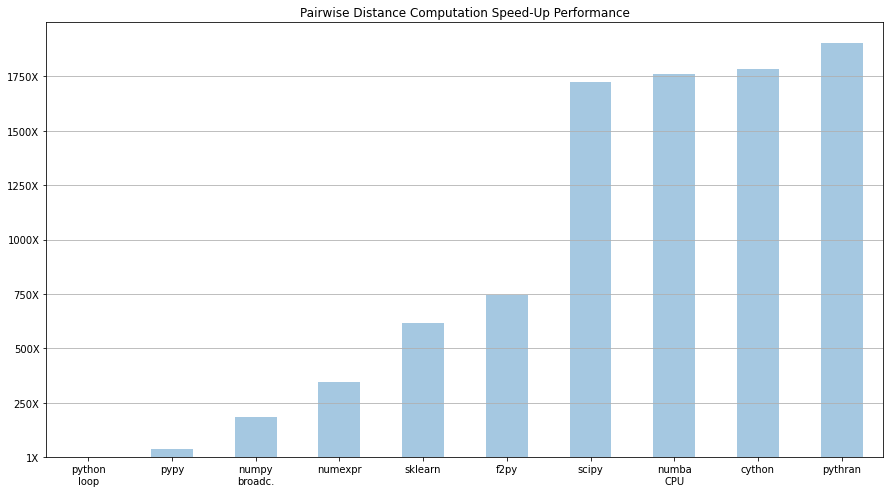

In [ ]:
labels = ['python\nloop', 'pypy', 'numpy\nbroadc.', 'numexpr', 'sklearn', 'f2py', 'scipy', 'numba\nCPU', 'cython', 'pythran']
#timings = [13.4, 0.0419, 0.017, 0.0167, 0.0129, 0.00987, 0.00912]
timings = [5.77,           0.191,  0.0394,         0.0208,    0.0117,    0.00967, 0.00418, 0.0041,       0.00404,  0.00379]
spdtimes = []
for timing in timings: spdtimes.append(timings[0]/timing)
x = np.arange(len(labels))

plt.figure(figsize=(15, 8))
#ax = plt.axes(xticks=x, yscale='log')
ax = plt.axes(xticks=x)
#ax.bar(x, timings, width=0.5, alpha=0.4, bottom=1E-6)
ax.bar(x, spdtimes, width=0.5, alpha=0.4, bottom=0)
ax.grid(which='major', axis='y')
ax.set_xlim(-0.5, len(labels) - 0.5)
#ax.set_ylim(1E-3, 1E1)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda i, loc: labels[int(i)]))
#ax.set_ylabel('time (s)')
#ax.set_ylabel('Speed-up times')
ytick_labels = ['1X', '250X', '500X', '750X', '1000X', '1250X', '1500X', '1750X', '2000X']
ax.set_yticklabels(ytick_labels)
ax.set_title("Pairwise Distance Computation Speed-Up Performance")
plt.show()